In [ ]:
!gdown https://drive.google.com/uc?id=1JqjuHZfmD01wFe8XyqWRzSm_GTygnwRC
!unzip -q shapenetcore_partanno_v0.zip

Downloading...
From: https://drive.google.com/uc?id=1JqjuHZfmD01wFe8XyqWRzSm_GTygnwRC
To: /content/shapenetcore_partanno_v0.zip
1.08GB [00:11, 93.2MB/s]


In [1]:
import os
import numpy as np
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from joblib import Parallel, delayed

In [2]:
category_dict = {}
with open('./PartAnnotation/synsetoffset2category.txt', 'r') as f:
    for line in f:
        ls = line.strip().split()
        category_dict[ls[0]] = ls[1]

category_dict

{'Airplane': '02691156',
 'Bag': '02773838',
 'Cap': '02954340',
 'Car': '02958343',
 'Chair': '03001627',
 'Earphone': '03261776',
 'Guitar': '03467517',
 'Knife': '03624134',
 'Lamp': '03636649',
 'Laptop': '03642806',
 'Motorbike': '03790512',
 'Mug': '03797390',
 'Pistol': '03948459',
 'Rocket': '04099429',
 'Skateboard': '04225987',
 'Table': '04379243'}

In [3]:
points_dir = './PartAnnotation/{}/points'.format(category_dict['Airplane'])
labels_dir = './PartAnnotation/{}/points_label'.format(category_dict['Airplane'])
LABELS = os.listdir(labels_dir)

In [4]:
points_files = glob(os.path.join(points_dir, '*.pts'))

In [5]:
LABELS_MAP = {
    'body': 'green',
    'wing': 'blue',
    'tail': 'red',
    'engine': 'pink'
}

In [12]:
point_clouds, point_cloud_labels = [], []
color_data, all_labels = [], []

for point_file in tqdm(points_files):
    point_cloud = np.loadtxt(point_file)
    file_id = point_file.split('/')[-1].split('.')[0]
    label_data, num_labels = {}, 0
    for label in LABELS_MAP.keys():
        label_file = os.path.join(labels_dir, label, file_id + '.seg')
        if os.path.exists(label_file):
            label_data[label] = np.loadtxt(label_file).astype('float32')
            num_labels = len(label_data[label])
    try:
        color_map = ['black'] * num_labels
        label_map = ['none'] * num_labels
        for label in LABELS_MAP.keys():
            for i, data in enumerate(label_data[label]):
                color_map[i] = LABELS_MAP[label] if data == 1 else color_map[i]
                label_map[i] = label if data == 1 else label_map[i]
        label_data = np.vstack(
            tuple([label_data[key] for key in LABELS_MAP.keys()]))
        point_clouds.append(point_cloud)
        point_cloud_labels.append(label_data)
        color_data.append(color_map)
        all_labels.append(label_map)
    except KeyError:
        pass

100%|██████████| 4045/4045 [06:20<00:00, 10.64it/s]


In [7]:
def visualize_data_plotly(index):
    fig = go.Figure(
        data=[
            go.Scatter3d(
                x=list(point_clouds[index][:, 0]),
                y=list(point_clouds[index][:, 1]),
                z=list(point_clouds[index][:, 2]),
                mode='markers', marker=dict(
                    size=12, color=color_data[index],
                    colorscale='Viridis',
                    opacity=0.8
                )
            )
        ]
    )
    fig.show()

In [17]:
def visualize_data_plt(index):
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection='3d')
    ax.scatter(
        point_clouds[index][:, 0],
        point_clouds[index][:, 1],
        point_clouds[index][:, 2],
        c=color_data[index], alpha=0.5, s=100
    )
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()

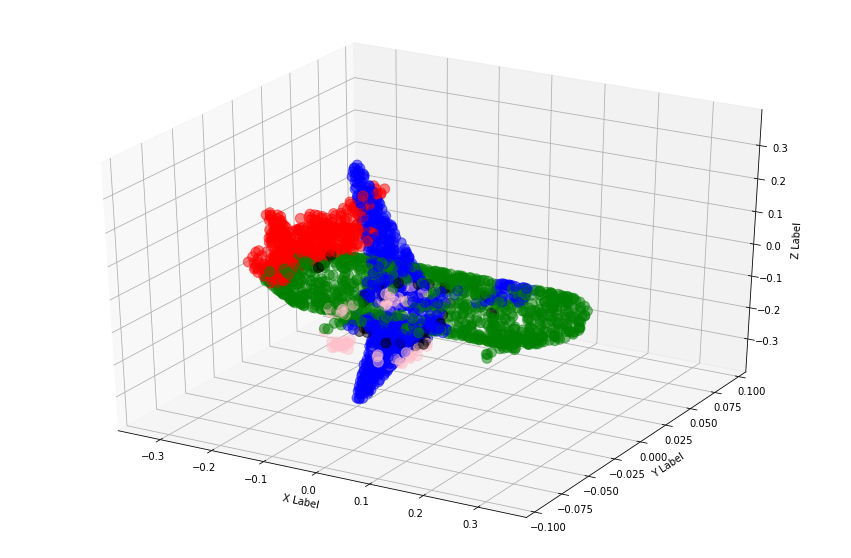

In [18]:
visualize_data_plt(0)

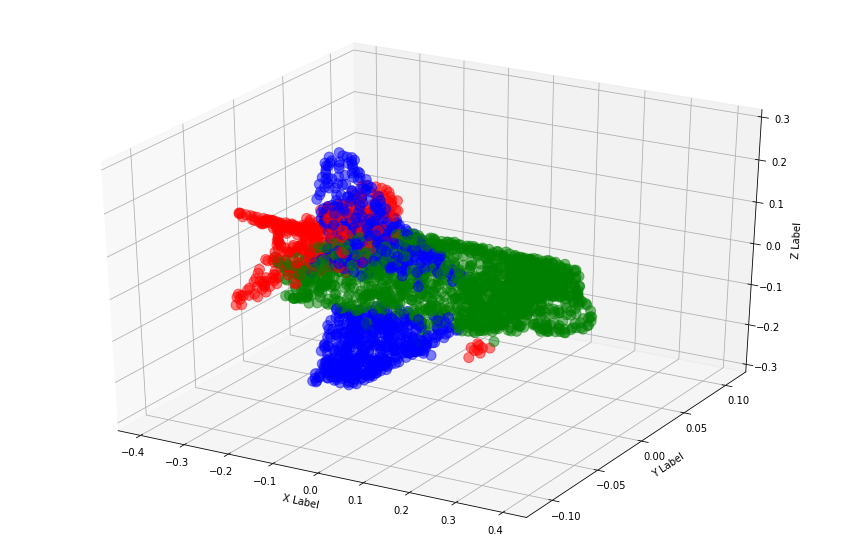

In [19]:
visualize_data_plt(300)